Upload Kaggle Api Token

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bardiakz","key":"c417b7967f884f93af9dc09bedec7390"}'}

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset
!unzip /content/coronahack-chest-xraydataset.zip

Import libraries

In [1]:
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
from google.colab.patches import cv2_imshow
import numpy as np

Read CSV file

In [2]:
summary = pd.read_csv('Chest_xray_Corona_dataset_Summary.csv')
summary

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


In [3]:
data = pd.read_csv('Chest_xray_Corona_Metadata.csv')
data = pd.DataFrame(data)
data.drop(labels=['Unnamed: 0','Label_2_Virus_category','Label'],axis = 1,inplace=True)
data

,X_ray_image_name,Dataset_type,Label_1_Virus_category
0,IM-0128-0001.jpeg,TRAIN,NaN
1,IM-0127-0001.jpeg,TRAIN,NaN
2,IM-0125-0001.jpeg,TRAIN,NaN
3,IM-0122-0001.jpeg,TRAIN,NaN
4,IM-0119-0001.jpeg,TRAIN,NaN
...,...,...,...
5905,person1637_virus_2834.jpeg,TEST,Virus
5906,person1635_virus_2831.jpeg,TEST,Virus
5907,person1634_virus_2830.jpeg,TEST,Virus
5908,person1633_virus_2829.jpeg,TEST,Virus


In [4]:
data['Label_1_Virus_category'].loc[(data['Label_1_Virus_category'] == 'Virus')] = 2
data['Label_1_Virus_category'].loc[(data['Label_1_Virus_category'] == 'bacteria')] = 1
data = data.fillna(0)
data.drop(data.loc[data['Label_1_Virus_category'] == 'Stress-Smoking'].index,inplace = True)
data

,X_ray_image_name,Dataset_type,Label_1_Virus_category
0,IM-0128-0001.jpeg,TRAIN,0
1,IM-0127-0001.jpeg,TRAIN,0
2,IM-0125-0001.jpeg,TRAIN,0
3,IM-0122-0001.jpeg,TRAIN,0
4,IM-0119-0001.jpeg,TRAIN,0
...,...,...,...
5905,person1637_virus_2834.jpeg,TEST,2
5906,person1635_virus_2831.jpeg,TEST,2
5907,person1634_virus_2830.jpeg,TEST,2
5908,person1633_virus_2829.jpeg,TEST,2


In [5]:
train_input = data[data.Dataset_type == 'TRAIN']['X_ray_image_name'].values
train_label = data[data.Dataset_type == 'TRAIN']['Label_1_Virus_category'].values
train_label = tf.convert_to_tensor(train_label,dtype=tf.int64)

test_input = data[data.Dataset_type == 'TEST']['X_ray_image_name'].values
test_label = data[data.Dataset_type == 'TEST']['Label_1_Virus_category'].values
test_label = tf.convert_to_tensor(test_label,dtype=tf.int64)

Preparing dataset


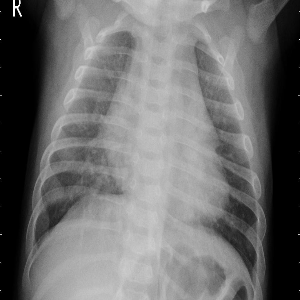

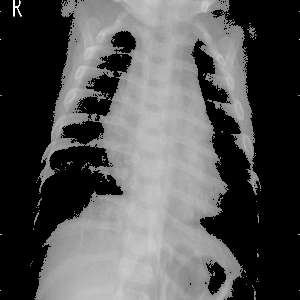

In [8]:
""" What I tried to do with images was to make them clearer with threshold and it has an signific effect on validation accuracy """

image = cv2.imread("/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/person1637_virus_2834.jpeg")
image = cv2.resize(image,(300,300))
cv2_imshow(image)

_, thresh = cv2.threshold(image,127,255,cv2.THRESH_TOZERO)
cv2_imshow(thresh)

In [6]:
def proccess_image_train(inputs):
  img = cv2.imread('/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/' + bytes.decode(inputs.numpy()))
  img = cv2.resize(img,(300,300))
  # _,img = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
  return img 

def get_image_train(inputs, outputs):
    img = tf.py_function(proccess_image_train, inp=[inputs], Tout=tf.int64)
    if(outputs == 0):
      outputs = [0,0,1]
    elif(outputs == 1):
      outputs = [0,1,0]
    else :
      outputs = [1,0,0]
    return img , outputs

import random 
def augment_data(inputs,outputs):
  r = random. randint(0,4)
  if r == 0:
    data_augmentation = tf.keras.Sequential([
      keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      keras.layers.experimental.preprocessing.RandomRotation(0.2)
      ])
    return data_augmentation(inputs),outputs
  else :
    return inputs , outputs


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
X1 = X2 = X3 =  AUTOTUNE 

train_dataset = tf.data.Dataset.from_tensor_slices((train_input,train_label))
train_dataset = train_dataset.shuffle(len(train_input))
train_dataset = train_dataset.map(get_image_train,num_parallel_calls=X1)
train_dataset = train_dataset.map(augment_data,num_parallel_calls=X3)
train_dataset = train_dataset.batch(batch_size=16)
train_dataset = train_dataset.prefetch(buffer_size=X2)

In [11]:
def proccess_image_test(inputs):
  img = cv2.imread('/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/' + bytes.decode(inputs.numpy()))
  img = cv2.resize(img,(300,300))
  # _,img = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
  return img 

def get_image_test(inputs, outputs):
    img = tf.py_function(proccess_image_test, inp=[inputs], Tout=tf.int64)
    if(outputs == 0):
      outputs = [0,0,1]
    elif(outputs == 1):
      outputs = [0,1,0]
    else :
      outputs = [1,0,0]
    return img , outputs

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
Y1 = Y2 =  AUTOTUNE 

test_dataset = tf.data.Dataset.from_tensor_slices((test_input,test_label))
test_dataset = test_dataset.shuffle(len(test_input))
test_dataset = test_dataset.map(get_image_test,num_parallel_calls=X1)
test_dataset = test_dataset.batch(batch_size=16)
test_dataset = test_dataset.prefetch(buffer_size=X2)

Building Model

In [13]:
base_model = keras.applications.EfficientNetB3(include_top= False,input_shape=(300, 300, 3))

for layer in base_model.layers:
    layer.trainable = False

cnn1 = keras.layers.Conv2D(64,(3,3),activation='relu')(base_model.output)
batch_1 = keras.layers.BatchNormalization(axis =1)(cnn1)

cnn2 = keras.layers.Conv2D(32,(3,3),activation='relu')(batch_1)
batch_2 = keras.layers.BatchNormalization(axis =1)(cnn2)

dropout_1 = keras.layers.Dropout(0.2)(batch_2)

flatten = keras.layers.Flatten()(dropout_1)

dense_1 = keras.layers.Dense(128,activation = 'relu')(flatten)
dropout_3 = keras.layers.Dropout(0.2)(dense_1)
dense_2 = keras.layers.Dense(64,activation='relu')(dropout_3)
dense_3 = keras.layers.Dense(3,activation = 'softmax')(dense_2)

model = keras.Model(base_model.input,dense_3)
  
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics='acc') 


Training and Fine tunning

In [14]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_test_1/', monitor='val_loss',mode='min',verbose=1, save_best_only=True)
history = model.fit(train_dataset,epochs = 5,validation_data=test_dataset,callbacks=[checkpoint_callback])

Epoch 1/5
331/331 [==============================] - ETA: 0s - loss: 0.6490 - acc: 0.7014
Epoch 00001: val_loss improved from inf to 1.30455, saving model to model_test_1/
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_test_1/assets
331/331 [==============================] - 151s 455ms/step - loss: 0.6490 - acc: 0.7014 - val_loss: 1.3045 - val_acc: 0.5865
Epoch 2/5
331/331 [==============================] - ETA: 0s - loss: 0.5248 - acc: 0.7648
Epoch 00002: val_loss improved from 1.30455 to 0.61416, saving model to model_test_1/
INFO:tensorflow:Assets written to: model_test_1/assets
331/331 [==============================] - 149s 450ms/step - loss: 0.5248 - acc: 0.7648 - val_loss: 0.6142 - val_acc: 0.8269
Epoch 3/5
331/331 [==============================] - ETA: 

In [ ]:
model = tf.keras.models.load_model('/content/model_test_1')
model.evaluate(test_dataset)

In [16]:
for layer in model.layers :
  layer.trainable = True

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_test_2/', monitor='val_loss',mode='min',verbose=1, save_best_only=True)
history = model.fit(train_dataset,epochs = 5,validation_data=test_dataset,callbacks=[checkpoint_callback])

Epoch 1/5
331/331 [==============================] - ETA: 0s - loss: 0.5839 - acc: 0.7409
Epoch 00001: val_loss improved from inf to 0.91070, saving model to model_test_2/
INFO:tensorflow:Assets written to: model_test_2/assets
331/331 [==============================] - 424s 1s/step - loss: 0.5839 - acc: 0.7409 - val_loss: 0.9107 - val_acc: 0.7051
Epoch 2/5
331/331 [==============================] - ETA: 0s - loss: 0.5268 - acc: 0.7754
Epoch 00002: val_loss did not improve from 0.91070
331/331 [==============================] - 369s 1s/step - loss: 0.5268 - acc: 0.7754 - val_loss: 0.9580 - val_acc: 0.7003
Epoch 3/5
331/331 [==============================] - ETA: 0s - loss: 0.4291 - acc: 0.8140
Epoch 00003: val_loss improved from 0.91070 to 0.90399, saving model to model_test_2/
INFO:tensorflow:Assets written to: model_test_2/assets
331/331 [==============================] - 424s 1s/step - loss: 0.4291 - acc: 0.8140 - val_loss: 0.9040 - val_acc: 0.7596
Epoch 4/5
331/331 [================

Checking the results

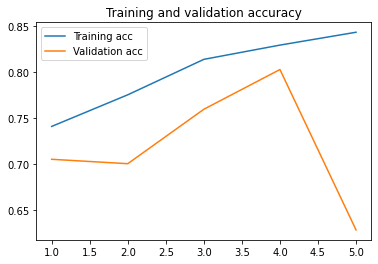

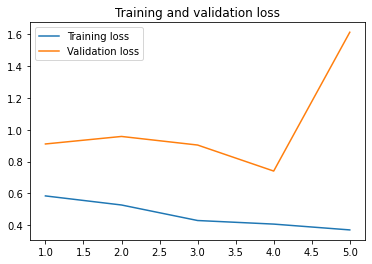

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc,  label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
model = tf.keras.models.load_model('/content/model_test_2')
model.evaluate(test_dataset)

39/39 [==============================] - 10s 253ms/step - loss: 0.7403 - acc: 0.8029


[0.7402702569961548, 0.8028846383094788]

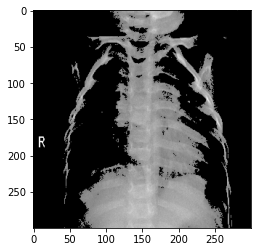

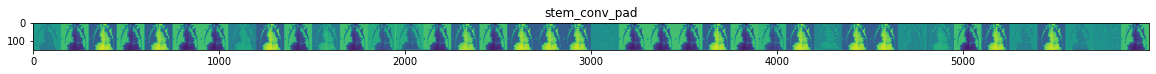

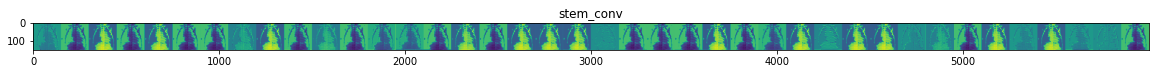

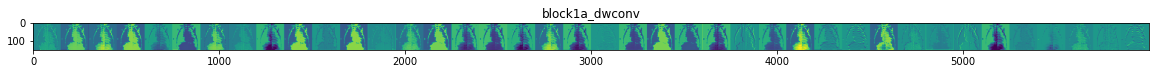

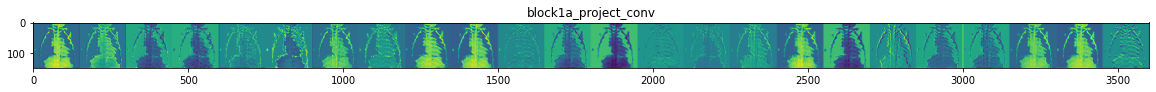

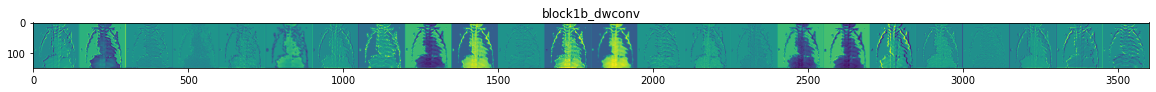

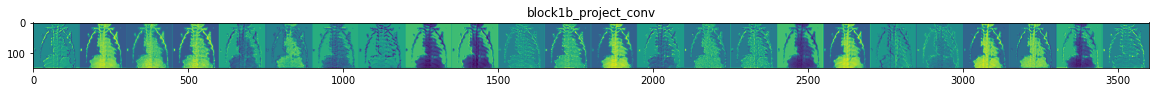

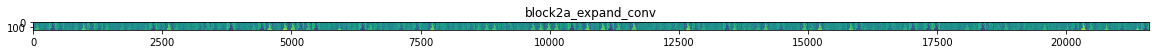

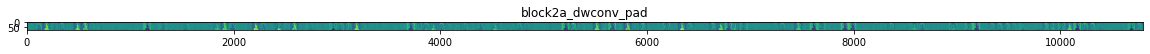

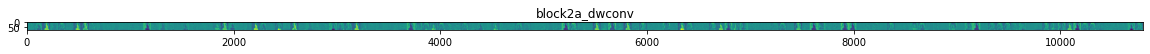

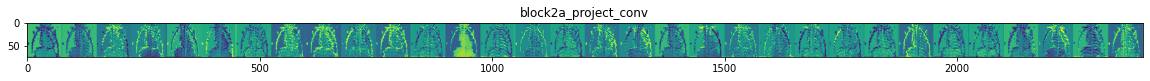

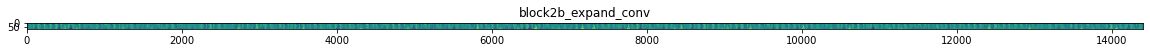

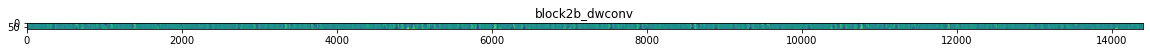

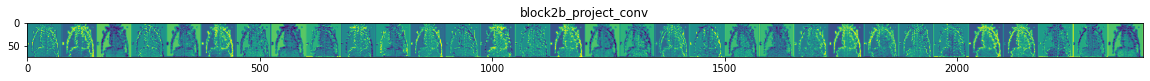

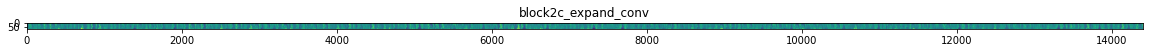

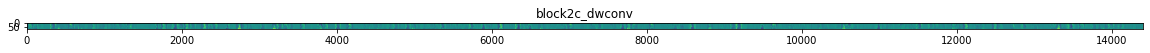

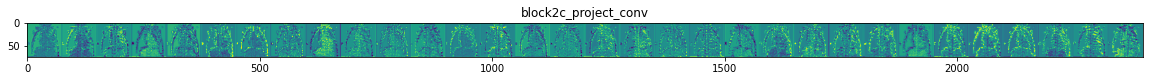

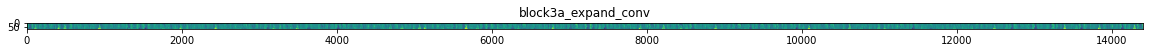

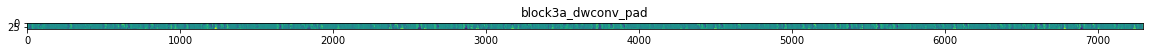

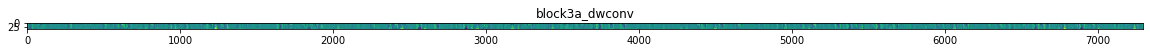

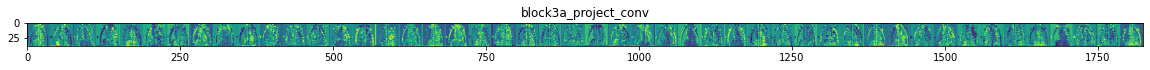

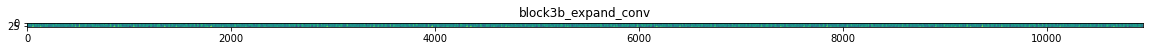

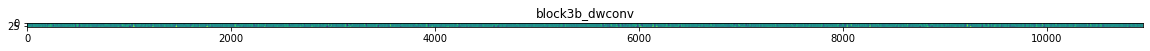

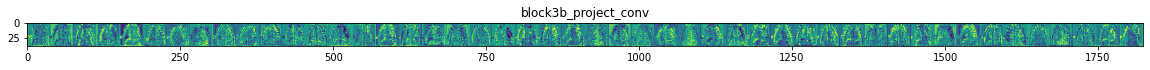

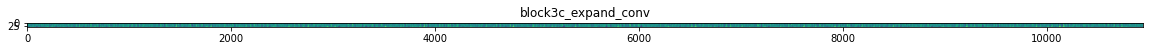

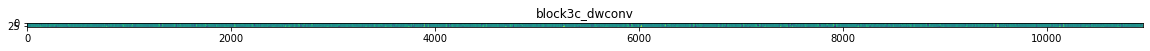

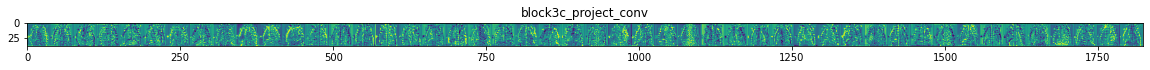

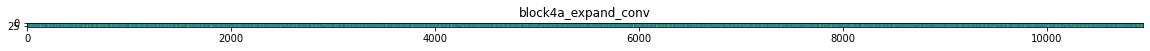

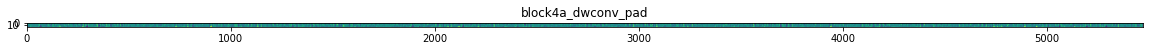

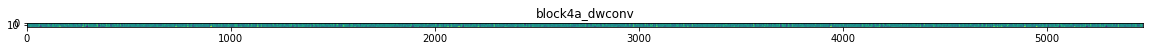

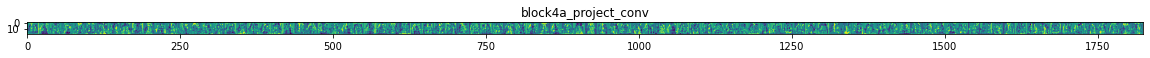

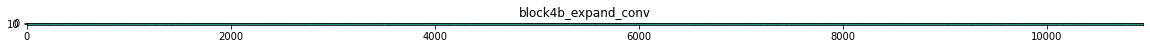

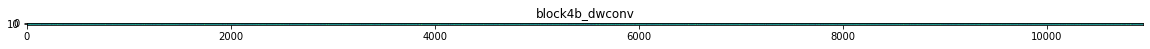

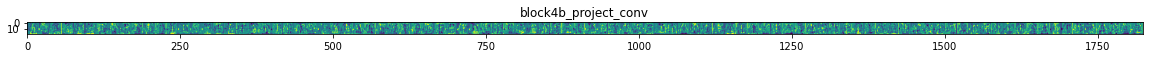

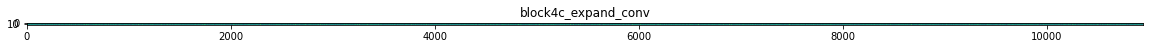

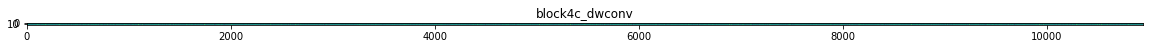

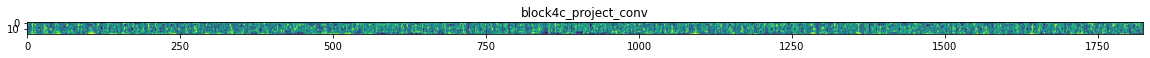

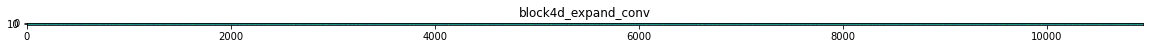

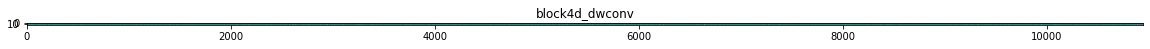

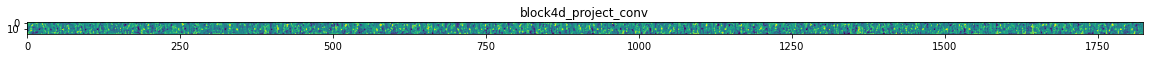

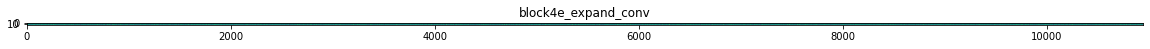

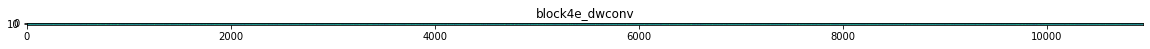

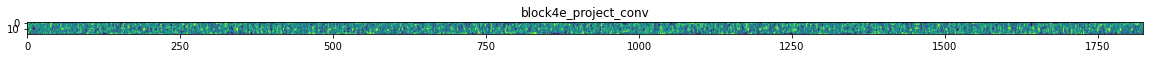

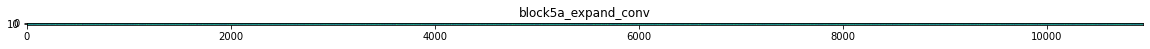

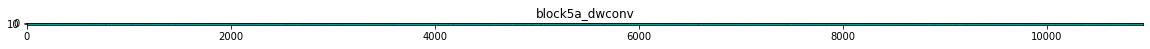

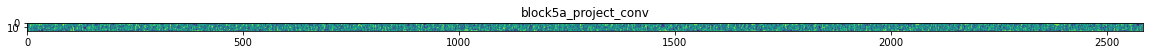

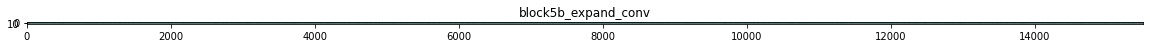

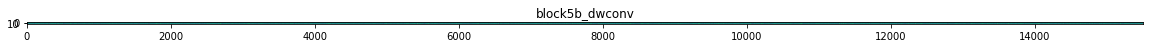

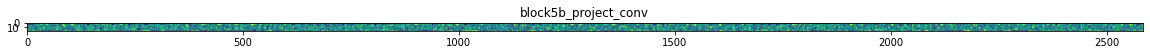

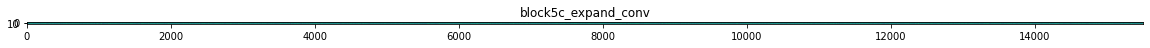

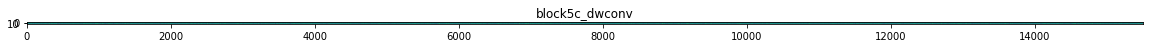

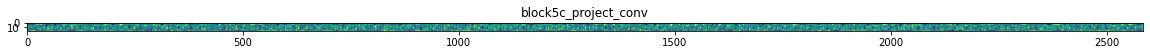

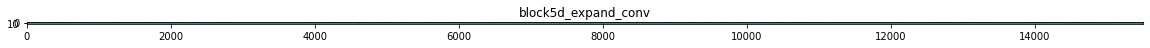

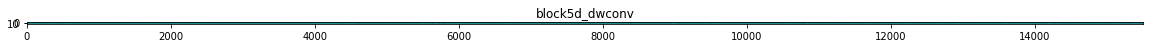

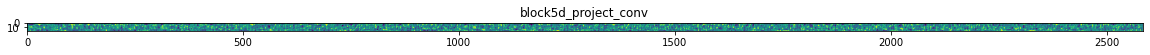

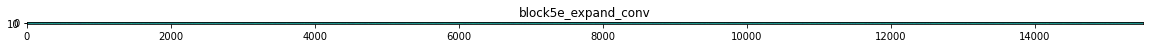

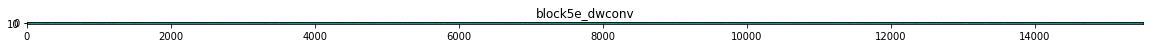

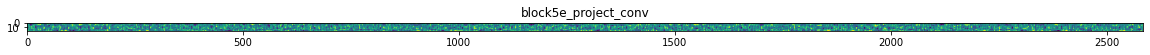

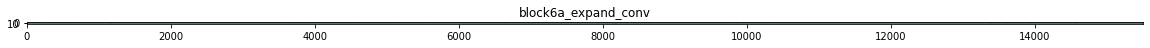

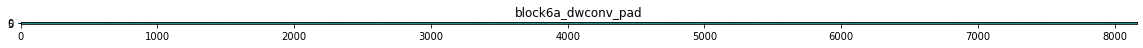

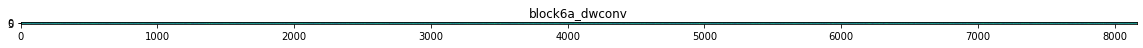

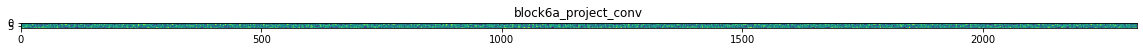

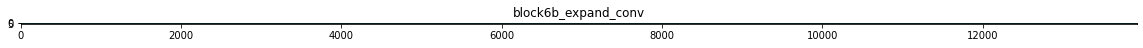

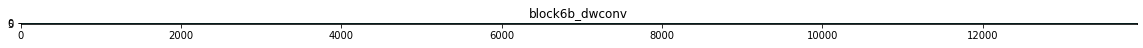

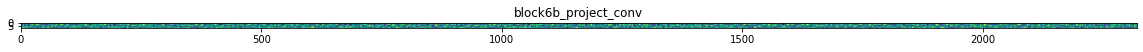

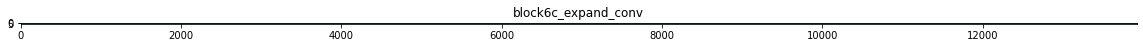

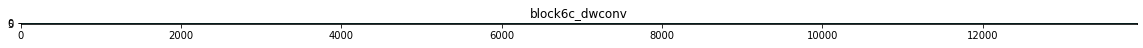

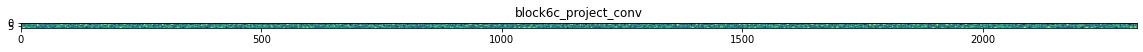

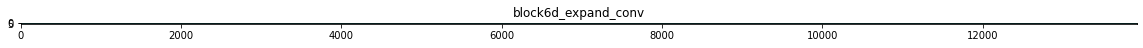

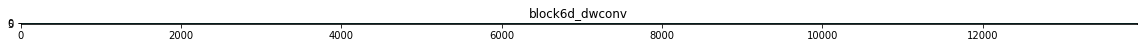

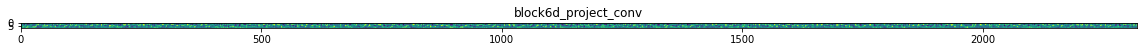

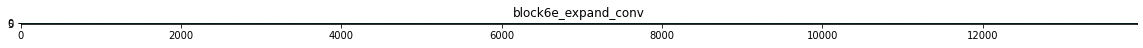

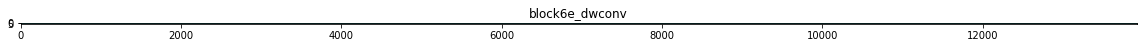

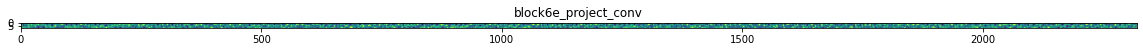

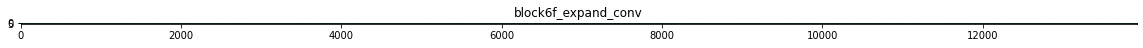

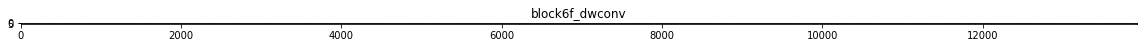

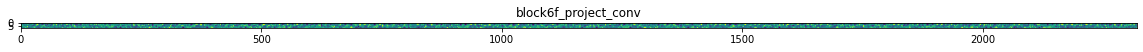

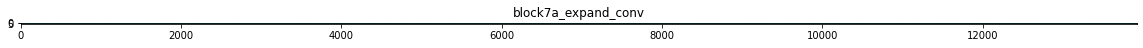

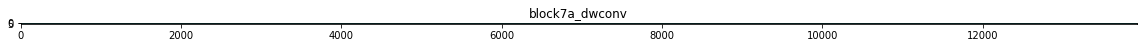

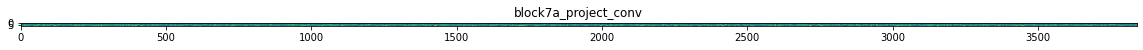

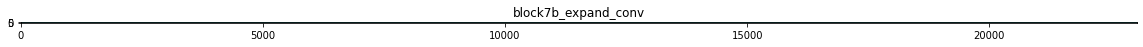

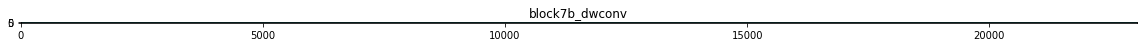

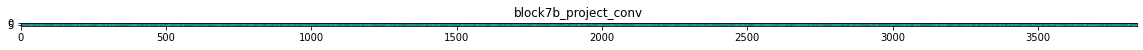

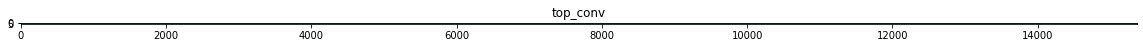

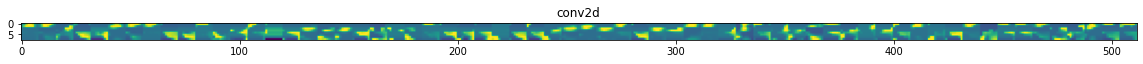

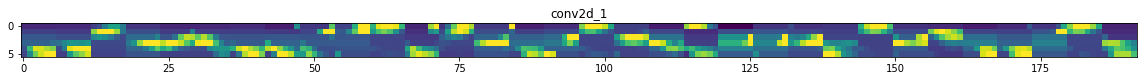

In [28]:
successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

image = cv2.imread("/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0128-0001.jpeg")
image = cv2.resize(image,(300,300))
_, thresh = cv2.threshold(image,127,255,cv2.THRESH_TOZERO)
plt.imshow(thresh)
thresh = np.expand_dims(thresh, axis=0)

successive_feature_maps = visualization_model.predict(thresh)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if 'conv' in  layer_name and len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 